In [1]:
from pathlib import Path 

from training_raster_clipper.core.models import TrainingConfiguration, TrainingFunctions 

from training_raster_clipper.core.logging import log_info

from training_raster_clipper.core.visualization import (
    plot_rgb_data_array,
    plot_array,
    plot_geodataframe,
)

import matplotlib.pyplot as plt


config = TrainingConfiguration(
    verbose = True,
    show_plots = True, 
    resolution = 60,
    band_names = ("B04", "B03", "B02", "B8A"),
    raster_input_path = Path(
        "D:/PROFILS/ESCHALK/DOWNLOADS/S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958/S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958.SAFE"
    ),
    polygons_input_path = (Path(".").resolve().parent / Path("resources/solution/polygons.geojson")),
    csv_output_path = (Path(".").resolve().parent / Path("generated/classified_points.csv")),
    raster_output_path=(Path(".").resolve().parent / Path("generated/sklearn_raster.tiff")),
    implementation_name="eschalk",
)
config

TrainingConfiguration(verbose=True, show_plots=True, resolution=60, band_names=('B04', 'B03', 'B02', 'B8A'), raster_input_path=WindowsPath('D:/PROFILS/ESCHALK/DOWNLOADS/S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958/S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958.SAFE'), polygons_input_path=WindowsPath('D:/Profils/eschalk/dev/playground/python/training/training-raster-clipper/resources/solution/polygons.geojson'), csv_output_path=WindowsPath('D:/Profils/eschalk/dev/playground/python/training/training-raster-clipper/generated/classified_points.csv'), raster_output_path=WindowsPath('D:/Profils/eschalk/dev/playground/python/training/training-raster-clipper/generated/sklearn_raster.tiff'), implementation_name='eschalk')

In [2]:
from training_raster_clipper.implementation.eschalk import (
    load_feature_polygons,
    load_sentinel_data,
    rasterize_geojson,
    produce_clips,
    persist_to_csv,
    classify_sentinel_data,
    persist_classification_to_raster,
)

interface = TrainingFunctions(
    load_feature_polygons=load_feature_polygons,
    load_sentinel_data=load_sentinel_data,
    rasterize_geojson=rasterize_geojson,
    produce_clips=produce_clips,
    persist_to_csv=persist_to_csv,
    classify_sentinel_data=classify_sentinel_data,
    persist_classification_to_raster=persist_classification_to_raster,
)
interface

TrainingFunctions(load_feature_polygons=<function load_feature_polygons at 0x0000017E4E9E4160>, load_sentinel_data=<function load_sentinel_data at 0x0000017E001FA710>, rasterize_geojson=<function rasterize_geojson at 0x0000017E01DCC3A0>, produce_clips=<function produce_clips at 0x0000017E01DCCEE0>, persist_to_csv=<function persist_to_csv at 0x0000017E01DCCF70>, classify_sentinel_data=<function classify_sentinel_data at 0x0000017E01DCD000>, persist_classification_to_raster=<function persist_classification_to_raster at 0x0000017E01DCD090>)

In [3]:
verbose = config.verbose
show_plots = config.show_plots

resolution = config.resolution
band_names = config.band_names

raster_input_path = config.raster_input_path
polygons_input_path = config.polygons_input_path
csv_output_path = config.csv_output_path
raster_output_path = config.raster_output_path

### (1) Load a GeoJSON file with `geopandas`

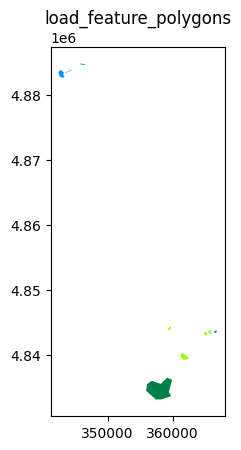

In [4]:
polygons = interface.load_feature_polygons(polygons_input_path)
if verbose:
    log_info(polygons, "polygons")
if show_plots:
    plot_geodataframe(polygons, f"{interface.load_feature_polygons.__name__}")


### (2) Load a Sentinel-2 raster with `rioxarray`

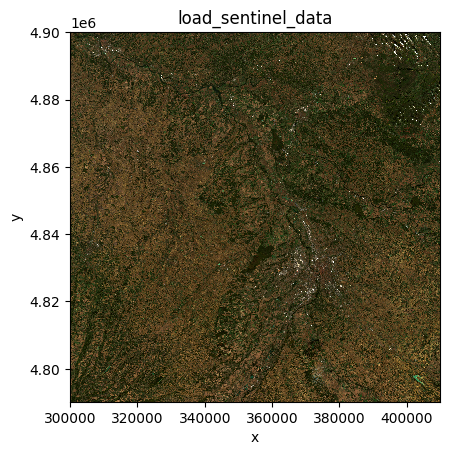

In [5]:
rasters = interface.load_sentinel_data(raster_input_path, resolution, band_names)
if verbose:
    log_info(rasters, "rasters")
if show_plots:
    plot_rgb_data_array(rasters, f"{interface.load_sentinel_data.__name__}")



### (3) Rasterize the polygons

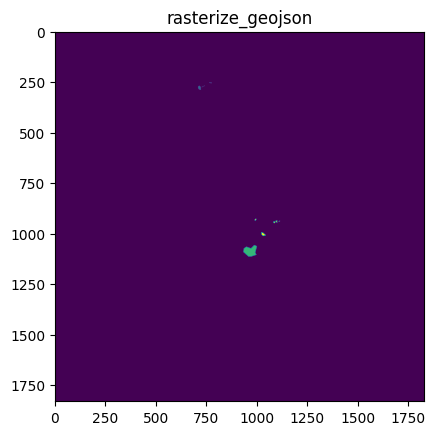

In [6]:

burnt_polygons, mapping = interface.rasterize_geojson(rasters, polygons)
if verbose:
    log_info(burnt_polygons, "burnt_polygons")
    log_info(mapping, "mapping")
if show_plots:
    plot_array(burnt_polygons, f"{interface.rasterize_geojson.__name__}")



### (4) Intersect the Sentinel-2 raster with polygons

In [7]:

classified_rgb_rows = interface.produce_clips(rasters, burnt_polygons, mapping)
if verbose:
    log_info(classified_rgb_rows, "classified_rgb_rows")



### (5) Persist the intersection to a CSV

In [8]:

interface.persist_to_csv(classified_rgb_rows, csv_output_path)
log_info(f"Written CSV output {csv_output_path}")



### (6) Train a machine learning model

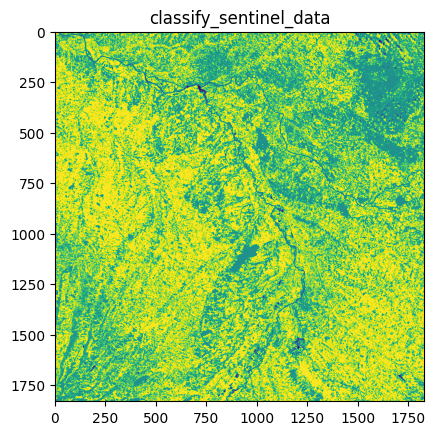

In [9]:
classification_result = interface.classify_sentinel_data(
    rasters, classified_rgb_rows
)
if verbose:
    log_info(classification_result, "classification_result")
if show_plots:
    plot_array(
        classification_result, f"{interface.classify_sentinel_data.__name__}"
    )


### (7) Export the classification raster result

In [10]:

interface.persist_classification_to_raster(
    raster_output_path, classification_result
)
log_info(f"Written Classified Raster to {csv_output_path}")

# --

log_info("Congratulations, you reached the end of the tutorial!")
